Based on: https://github.com/jdtoscano94/Learning-Scientific_Machine_Learning_Residual_Based_Attention_PINNs_DeepONets/blob/main/Tutorials/PINNs/3_Poisson1D_Dirichlet.ipynb

Solving:
$$-\triangle u = \pi^2 \sin(\pi x)$$
With boundary conditions 
$$u(-1) = 0, u(1) = 0$$

Explicit solution: $u(x) = \sin(\pi x)$

Libraries

In [1]:
import torch
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
from pyDOE import lhs
import scipy.io

In [2]:
torch.set_default_dtype(torch.float)

torch.manual_seed(1234)
np.random.seed(1234)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Tuning params

In [3]:
steps = 5000
lr = 0.001
layers = np.array([1, 50, 50, 20, 50, 50, 1])

total_points = 500
Nu = 2 # number of boundary points
Nf = 250 # number of collocation points

In [4]:
# function to approximate
def f_real(x):
    return torch.sin(np.pi * x) 

def PDE(x):
    return -1 * np.pi**2 * torch.sin(np.pi * x)

In [5]:
class FCN (nn.Module):
    def __init__(self, layers):
        super().__init__()
        
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction='mean')
        
        self.linears = nn.ModuleList([nn.Linear (layers[i], layers[i+1]) for i in range(len(layers)-1)])
                
        # Xavier initialization
        for i in range (len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain = 1.0)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x)
        
        a = x.float()
        
        # ugly way to make last layer linear
        for layer in self.linears[:-1]:
            z = layer(a)
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    def loss_BC(self, x, y):
        return self.loss_function(self.forward(x), y)
    
    def loss_PDE(self, x):
        x.requires_grad = True
        u = self.forward(x)
        u_x = autograd.grad(u, x, torch.ones([x.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        u_xx = autograd.grad(u_x, x, torch.ones([x.shape[0], 1]).to(device), create_graph=True)[0]
        
        return self.loss_function(u_xx, PDE(x))
    
    def loss (self, x_BC, y_BC, x_PDE):
        return self.loss_BC(x_BC, y_BC) + self.loss_PDE(x_PDE)

Generate data

In [6]:
x = torch.linspace(-1, 1, total_points).view(-1, 1).to(device)
y = f_real(x)

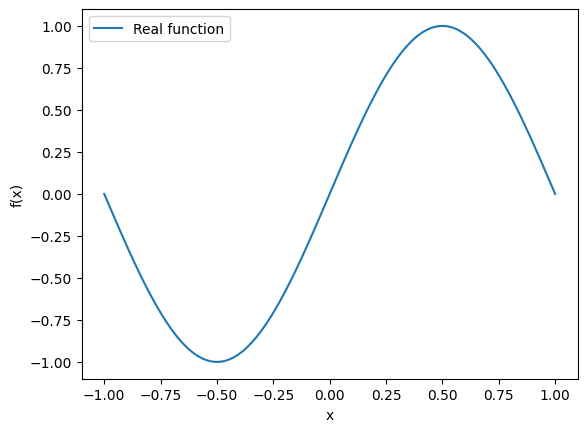

In [7]:
fig, ax1 = plt.subplots()
ax1.plot(x.detach().numpy(), y.detach().numpy(), label='Real function')
ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.tick_params(axis='y')
ax1.legend()

In [8]:
x_BC = torch.tensor([-1., 1.]).view(-1, 1).float().to(device)
y_BC = torch.tensor([0., 0.]).view(-1, 1).float().to(device)

#Select Nf points
# Latin Hypercube sampling for collocation points 
x_PDE = torch.tensor([-1.]) + torch.tensor([2.]) * lhs(1,Nf)
x_PDE = torch.vstack((x_PDE,x_BC))
x_PDE = x_PDE.float().to(device)

Defining our NN

In [9]:
model = FCN(layers).to(device)
params = list(model.parameters())
optimizer = optim.Adam(params, lr=lr)

In [10]:
start_time = time.time()

for i in range(steps):
    optimizer.zero_grad()
    loss = model.loss(x_BC, y_BC, x_PDE)
    loss.backward()
    optimizer.step()
    if i % 1000 == 0:
        print (f'Step {i}: Loss {loss.item()}')
        
end_time = time.time()
print (f'Training time: {end_time - start_time}s')

Step 0: Loss 46.14834976196289
Step 1000: Loss 0.001144907670095563
Step 2000: Loss 0.00034584326203912497
Step 3000: Loss 6.207552360137925e-05
Step 4000: Loss 2.6255544071318582e-05
Training time: 32.17942667007446s


Plots!

In [11]:
yh = model(x).detach().cpu().numpy()
y = f_real(x).detach().cpu().numpy()

g = x.clone()
g.requires_grad = True
f = model(g)
f_x = autograd.grad(f, g, torch.ones([g.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
f_x = f_x.detach().cpu().numpy()

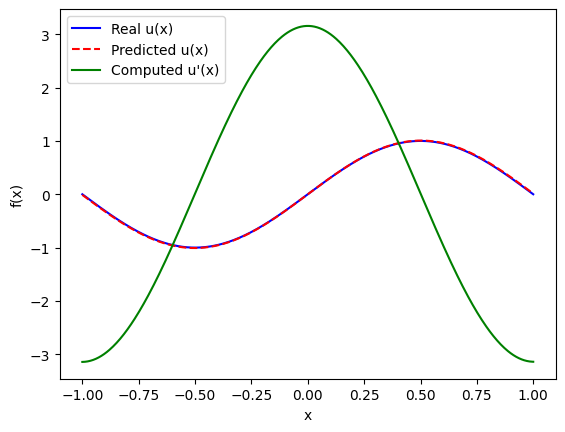

In [13]:
fig, ax1 = plt.subplots()
ax1.plot(x, y, color = 'blue', label='Real u(x)')
ax1.plot(x, yh, color = 'red', linestyle = 'dashed', label='Predicted u(x)')
ax1.plot(x, f_x, color = 'green', label='Computed u\'(x)')
ax1.set_xlabel('x',color='black')
ax1.set_ylabel('f(x)',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')